# 1st Assignment: N-gram Language models

---
>Vasileios Galanos <br>
>Registration Number p3351902 <br>
>vgalanos@aueb.gr

This notebook accompanied with the report given provides our solution on the 1st assignment for the Text Analytics course at Data Science MSc at AUEB. <br>

## (i) Implementation of bigram and trigram language model
### Training models
#### Import corpus

In [1]:
import nltk
import re
import numpy as np
import math

from pprint import pprint
from collections import Counter
from nltk import sent_tokenize
from nltk.corpus import brown
from nltk.tokenize import RegexpTokenizer
from matplotlib import pyplot as plt

nltk.download('brown', quiet=True) # download corpus
total_corpus = ' '.join(brown.words()) # join words into a single string

#### Corpus preprocessing & sentence splitting

In [2]:
total_corpus = re.sub(r"(''|``)", '', total_corpus) # replace double quotes
total_corpus = re.sub(r"(\!\s*)+", '!', total_corpus) # replace multiple !
total_corpus = re.sub(r"(\?\s*)+", '?', total_corpus) # replace multiple ?
total_corpus = re.sub(r'\s+', ' ', total_corpus) # replace multiple whitespace by single

# split corpus into sentences
corpus_sentences = sent_tokenize(total_corpus)

#### Split data into train, dev and test set

In [3]:
np.random.shuffle(corpus_sentences) # randomize sentence ordering

# Split dataset
total_length = len(corpus_sentences)
train_set = corpus_sentences[0:int((total_length*7)/10)]
dev_set = corpus_sentences[int((total_length*7)/10)+1:int((total_length*9)/10)]
test_set = corpus_sentences[int((total_length*9)/10)+1:total_length]

#### Vocabulary creation 

In [4]:
def get_vocabulary(word_sequence, tokenizer, min_freq=10):
    
    # calculate word frequencies
    tokens = tokenizer.tokenize(word_sequence)
    tokens = [token.lower() for token in tokens] #lowercase
    count = nltk.FreqDist(tokens)

    #create vocabulary only with words that appear in corpus > MIN_FREQ times
    count_new = dict(filter(lambda elem: elem[1] > MIN_FREQ,count.items()))
    return list(count_new.keys())

# minimum word frequency
MIN_FREQ = 10 

# Pattern for tokenization of sentences: includes: words ( ) . , 
PATTERN = '\w+|\(|\)|\.|\,'    

# define tokenizer using regular expressions
word_tokenizer = RegexpTokenizer(pattern=PATTERN) 

vocabulary = get_vocabulary(' '.join(train_set), word_tokenizer, MIN_FREQ)
print('Vocabulary length:',len(vocabulary),'words')

Vocabulary length: 6249 words


#### Tokenize sentences, replace non common words

In [5]:
# function that tokenizes and replaces uncommon words
def tokenize_n_replace(sentence, tokenizer, vocab, unknown_char):
    sent_tok = tokenizer.tokenize(sentence)
    sent_tok = [token.lower() for token in sent_tok] #lowercase
    sent_tok2 = ['<UNK>' if elem not in vocab else elem for elem in sent_tok]
    return sent_tok2

#tokenize sentences
sentences_tokenized = [tokenize_n_replace(s, word_tokenizer, vocabulary, '<UNK>') for s in train_set]

#### Create and count n-grams frequencies

In [6]:
def pad_sent(s, left_symbol='<s>',right_symbol ='<e>',n=1):
    return [left_symbol]*n + s + [right_symbol]*n

unigram_counter = Counter()
bigram_counter = Counter()
trigram_counter = Counter()

for sent in sentences_tokenized:

    bigram_pad_sent = pad_sent(sent)
    unigram_counter.update([(gram,) for gram in bigram_pad_sent])
    bigram_counter.update([(gram1,gram2) for gram1,gram2 in zip(bigram_pad_sent,bigram_pad_sent[1:])]) 
    trigram_pad_sent = pad_sent(sent,n=2)
    trigram_counter.update([(gram1,gram2,gram3) for gram1,gram2,gram3 in zip(trigram_pad_sent,trigram_pad_sent[1:],trigram_pad_sent[2:])]) 

### Calculate bi-gram probability

In [36]:
alpha = 0.009 # hyperparameter for add-a smoothing

def bigram_prob_calc(w1,w2,b_cntr,u_cntr,vcb,a):
        
    #Calculate vocab size 
    vocab_size = len(vcb)
    #Bigram prob + add-a smoothing
    return (b_cntr[(w1, w2)] +a) / (u_cntr[(w1,)] + a*vocab_size)

bigram_prob_calc('they','had',bigram_counter,unigram_counter,vocabulary,alpha)

0.06982577424078619

### Calculate tri-gram probability

In [37]:
alpha = 0.003 
def trigram_prob_calc(w1,w2,w3,t_cntr,b_cntr,vcb,a):
        
    #Calculate vocab size 
    vocab_size = len(vcb)
    #Trigram prob + add-a smoothing
    return (t_cntr[(w1, w2, w3)] +a) / (b_cntr[(w1,w2)] + a*vocab_size)

trigram_prob_calc('by','her','own',trigram_counter,bigram_counter,vocabulary,alpha)

0.02805358990853914

### Calculate sentence log probability

In [9]:
def b_log_prob(snt, a):
    snt = pad_sent(snt)
    sm = 0
    bg_cnt = 0
    for idx in range(1, len(snt)):
        sm += math.log2(bigram_prob_calc(snt[idx-1], snt[idx], bigram_counter, unigram_counter, vocabulary, a))
        bg_cnt += 1
    return sm,bg_cnt

def t_log_prob(snt, a):
    snt = pad_sent(snt,n=2)
    sm = 0
    tg_cnt = 0
    for idx in range(2,len(snt)):
        sm += math.log2(trigram_prob_calc(snt[idx-2], snt[idx-1], snt[idx], trigram_counter, bigram_counter, vocabulary, a))
        tg_cnt += 1
    return sm,tg_cnt

## (ii) Log-Probability comparison between real and random sentences

#### Comparison using one sentence from the test set

In [107]:
def get_random_sentence(size):
    random_word_list = np.random.choice(vocabulary, size, replace=True)
    return ' '.join(random_word_list)

#tokenize sentences
sentences_tokenized = [tokenize_n_replace(s, word_tokenizer, vocabulary, '<UNK>') for s in test_set]

real_sent = sentences_tokenized[np.random.randint(0,len(sentences_tokenized)-1)]
random_sent = tokenize_n_replace(get_random_sentence(len(real_sent)), word_tokenizer, vocabulary, '<UNK>')
print('Real sentence from test-set: ',' '.join(real_sent)
      ,'Random sentence: ',' '.join(random_sent),sep='\n')
print('___'*20)
print('Bigram log-probabilities:')
print('real sentence: ',round(b_log_prob(real_sent,0.009)[0],4)
      ,', random sentence: ',round(b_log_prob(random_sent,0.009)[0],4))
print('Trigram log-probabilities:')
print('real sentence: ',round(t_log_prob(real_sent,0.003)[0],4)
      ,', random sentence: ',round(t_log_prob(random_sent,0.003)[0],4))

Real sentence from test-set: 
i am only a simple soldier .
Random sentence: 
remarkable stem assumptions bore inevitably today uneasy
____________________________________________________________
Bigram log-probabilities:
real sentence:  -50.6208 , random sentence:  -115.2969
Trigram log-probabilities:
real sentence:  -63.5887 , random sentence:  -113.4888


#### Comparison using multiple sentences and plot

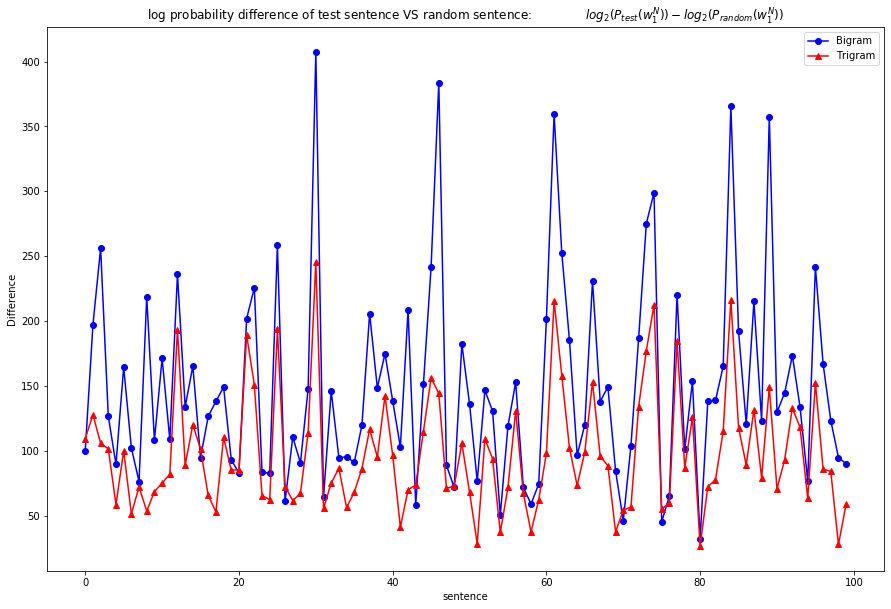

In [100]:
# testing:
diffs_b = []
diffs_t = []
N=100
for i in range(0,N):
    real_sent = sentences_tokenized[i]
    random_sent = tokenize_n_replace(
        get_random_sentence(len(real_sent)), word_tokenizer, vocabulary, '<UNK>')

    real_sent_b_log_prob,_ = b_log_prob(real_sent,0.009)
    rand_b_log_prob,_ = b_log_prob(random_sent,0.009)
    real_sent_t_log_prob,_ = t_log_prob(real_sent,0.003)
    rand_t_log_prob,_ = t_log_prob(random_sent,0.003)
    diffs_b.append(real_sent_b_log_prob-rand_b_log_prob)
    diffs_t.append(real_sent_t_log_prob-rand_t_log_prob)
    
#plot probabilites
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('log probability difference of test sentence VS random sentence: \
             $log_2(P_{test}(w_1^N))-log_2(P_{random}(w_1^N))$')
x = range(0,N)
ax.plot(x,diffs_b,'-ob')
ax.plot(x,diffs_t,'-^r')
ax.legend(['Bigram','Trigram'])
ax.set_xlabel('sentence')
ax.set_ylabel('Difference')
plt.show()

#### Examine sentences where trigrams performed better

In [42]:
for i,s in enumerate(sentences_tokenized[:N]):
    if diffs_b[i] < diffs_t[i]:
        print (' '.join(s))

he went to the hotel <UNK> and <UNK> <UNK> .
mr . <UNK> , c . c . b .
we ll work hard , mr . morgan .
no <UNK> for him .
1 and 2 ) .
but not any more .
<UNK> <UNK> .


## (iii) LM Cross entropy & perplexity

In [43]:
def CrossEntropy_Perplexity(data_set, model, alpha=1, lamda=1, alpha_b=1, alpha_t=1):

    if model not in ('bigram','trigram','interpolated'):
        raise TypeError("Unknown model selection, Choose from (bigram,trigram,'interpolated')")
    if not all([(0<=a<=1) for a in [alpha,alpha_b,alpha_t]]):
        raise TypeError("Invalid alpha value. Choose alpha from [0,1]")
    
    sum_prob = 0
    sum_cnt = 0
    for sent in data_set:
        if model=='bigram':
            tmp_lg_pb, tmp_cnt = b_log_prob(sent,alpha)
        elif model=='trigram':
            tmp_lg_pb, tmp_cnt = t_log_prob(sent,alpha)
        else: # interpolated model
            tmp_lg_pb, tmp_cnt = int_log_prob(sent,lamda,alpha_b,alpha_t)
        sum_prob += tmp_lg_pb
        sum_cnt += tmp_cnt

    HC = -sum_prob / sum_cnt
    perpl = math.pow(2,HC)
    return(HC,perpl)

### -- Alpha-Tuning --

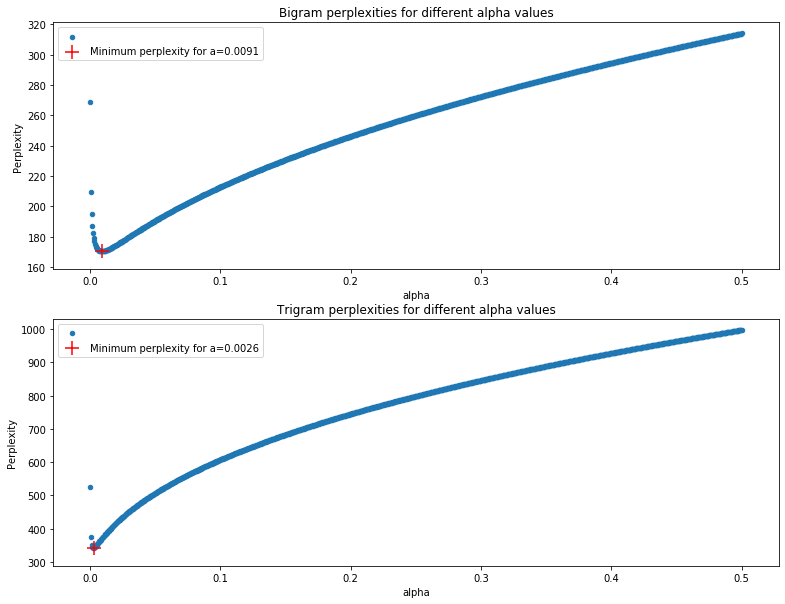

Bigram best alpha:  0.00911 Trigram best alpha:  0.0026


In [102]:
dev_tokenized = [tokenize_n_replace(s, word_tokenizer, vocabulary, '<UNK>') for s in dev_set]
alphas = np.linspace(0.0001,0.5,1000)
models = ['bigram','trigram']
best_alphas = []
fig, axs = plt.subplots(2, 1,figsize=(13,10))

for i in range(len(models)):
    
    dev_perpl = [CrossEntropy_Perplexity(dev_tokenized, models[i],alpha=a)[1] for a in alphas]
    
    ymin = min(dev_perpl)
    xpos = dev_perpl.index(ymin)
    xmin = alphas[xpos]    
    best_alphas.append(xmin)
    
    axs[i].title.set_text(models[i].capitalize()+' perplexities for different alpha values')
    axs[i].scatter(alphas,dev_perpl,s=20)
    axs[i].scatter(xmin,ymin,s=200,marker='+',c='r')
    axs[i].set_xlabel("alpha")
    axs[i].legend(['','Minimum perplexity for a='+str(round(xmin,4))])
    axs[i].set_ylabel("Perplexity")
plt.show()
print('Bigram best alpha: ',round(best_alphas[0],5)
     ,'Trigram best alpha: ',round(best_alphas[1],5))

#### Bigram LM Cross entropy & perplexity

In [44]:
HC,perpl = CrossEntropy_Perplexity(sentences_tokenized, 'bigram',alpha=0.009)
print("Cross Entropy: {0:.3f}".format(HC))
print("perplexity: {0:.3f}".format(perpl))

Cross Entropy: 7.439
perplexity: 173.530


#### Tri-gram LM Cross entropy & perplexity

In [35]:
HC,perpl = CrossEntropy_Perplexity(sentences_tokenized, 'trigram',alpha=0.003)
print("Cross Entropy: {0:.3f}".format(HC))
print("perplexity: {0:.3f}".format(perpl))

Cross Entropy: 8.467
perplexity: 353.731


## (iv) Interpolated Model

In [61]:
def int_log_prob(snt,lamda,alpha_b,alpha_t):
    snt = pad_sent(snt,2)
    sm = 0
    int_cnt = 0
    for idx in range(2,len(snt)):
        bigram_prob  = bigram_prob_calc(snt[idx-1],snt[idx],bigram_counter,unigram_counter,vocabulary,alpha_b)
        trigram_prob = trigram_prob_calc(snt[idx-2],snt[idx-1],snt[idx],trigram_counter,bigram_counter,vocabulary,alpha_t)
        sm += (lamda * math.log2(trigram_prob)) +((1-lamda) * math.log2(bigram_prob))
        int_cnt += 1
    return sm,int_cnt

HC,perpl = CrossEntropy_Perplexity(sentences_tokenized, 'interpolated'
                                   ,lamda = 0.1,alpha_b = 0.009,alpha_t = 0.003)
print("Cross Entropy: {0:.3f}".format(HC))
print("perplexity: {0:.3f}".format(perpl))

Cross Entropy: 7.649
perplexity: 200.730


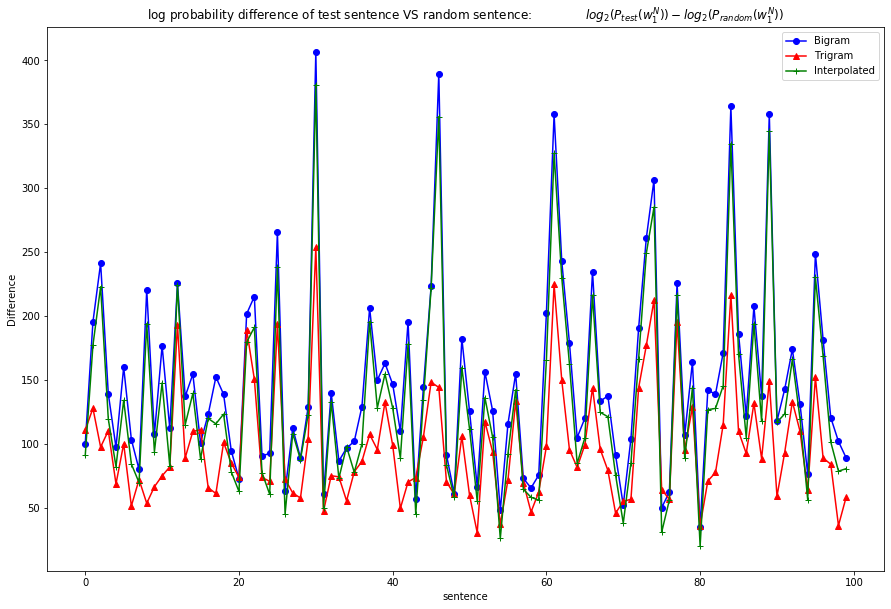

In [98]:
# testing:
diffs_i = []
N=100
for i in range(0,N):
    real_sent = sentences_tokenized[i]
    random_sent = tokenize_n_replace(
        get_random_sentence(len(real_sent)), word_tokenizer, vocabulary, '<UNK>')

    real_sent_i_log_prob,_ = int_log_prob(real_sent,alpha_b=0.009,alpha_t=0.003,lamda=0.1)
    rand_i_log_prob,_ = int_log_prob(random_sent,alpha_b=0.009,alpha_t=0.003,lamda=0.1)
    diffs_i.append(real_sent_i_log_prob-rand_i_log_prob)
    
#plot probabilites
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('log probability difference of test sentence VS random sentence: \
             $log_2(P_{test}(w_1^N))-log_2(P_{random}(w_1^N))$')
x = range(0,N)
ax.plot(x,diffs_b,'-ob')
ax.plot(x,diffs_t,'-^r')
ax.plot(x,diffs_i,'-+g')
ax.legend(['Bigram','Trigram','Interpolated'])
ax.set_xlabel('sentence')
ax.set_ylabel('Difference')
plt.show()

### -- Lambda-Tuning --

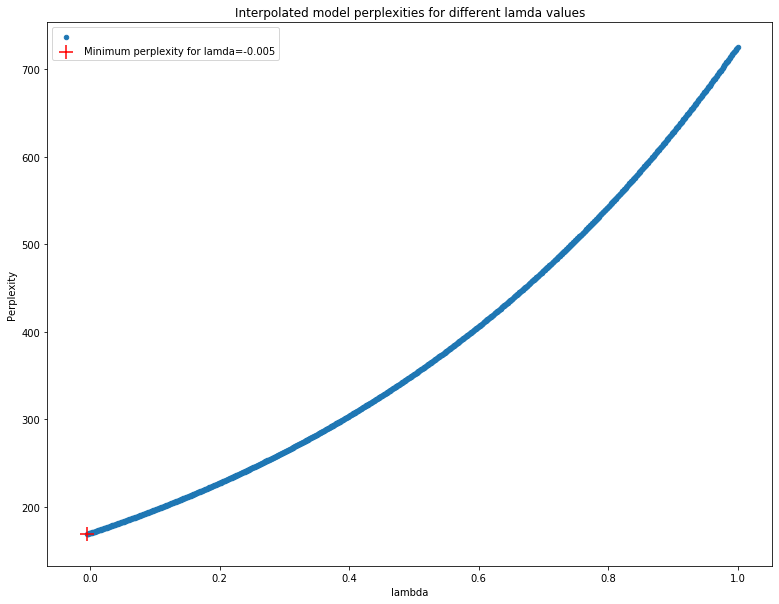

Interpolated model best lamda:  -0.005


In [55]:
lamdas = np.linspace(-0.005,1,1000)
dev_perpl = [CrossEntropy_Perplexity(dev_tokenized, 'interpolated'
                                     ,lamda=l,alpha_b=0.009,alpha_t=0.003)[1] for l in lamdas]

fig, ax = plt.subplots(figsize=(13,10))
    
ymin = min(dev_perpl)
xpos = dev_perpl.index(ymin)
xmin = lamdas[xpos]    
    
ax.set_title('Interpolated model perplexities for different lamda values')
ax.scatter(lamdas,dev_perpl,s=20)
ax.scatter(xmin,ymin,s=200,marker='+',c='r')
ax.set_xlabel("lambda")
ax.legend(['','Minimum perplexity for lamda='+str(round(xmin,4))])
ax.set_ylabel("Perplexity")
plt.show()
print('Interpolated model best lamda: ',round(xmin,5))

### Kneser-Ney smoothing

In [7]:
from nltk.lm.preprocessing import flatten
from nltk import bigrams, trigrams

In [8]:
train_sentences_tokenized = [tokenize_n_replace(s, word_tokenizer, vocabulary, '<UNK>') for s in train_set]

train_2grams = list(bigrams(flatten(pad_sent(sent) for sent in train_sentences_tokenized)))

In [9]:
train_3grams = list(trigrams(flatten(pad_sent(sent, n=2) for sent in train_sentences_tokenized)))

In [10]:
from kneser_ney import KneserNeyLM

bigram_kneser = KneserNeyLM(2, train_2grams, end_pad_symbol='<e>')
trigram_kneser = KneserNeyLM(3, train_3grams, end_pad_symbol='<e>')

In [12]:
test_sentences_tokenized = [tokenize_n_replace(s, word_tokenizer, vocabulary, '<UNK>') for s in test_set]

test_2grams = list(bigrams(flatten(pad_sent(sent) for sent in test_sentences_tokenized)))
test_3grams = list(trigrams(flatten(pad_sent(sent, n=2) for sent in test_sentences_tokenized)))

entropy2_kneser = 0
N = 0
for j,k in test_2grams:
    if k != '<s>':
        entropy2_kneser += math.log2(-bigram_kneser.score_sent((j,k)))
        N += 1

entropy2_kneser = entropy2_kneser/N

entropy3_kneser = 0
N2 = 0
for j,k,l in test_3grams:
    if l != '<s>':
        entropy3_kneser += math.log2(-trigram_kneser.score_sent((j,k,l)))
        N2 += 1

entropy3_kneser = entropy3_kneser/N2

print('======= Perplexity =======')
print('{0:10s} {1:10s}'.format('Model', 'Kneser-Ney smooth'))
print('{0:10s} {1:10}'.format('Bigram', float('%.4g' % pow(2.0, entropy2_kneser))))
print('{0:10s} {1:10}'.format('Trigram', float('%.4g' % pow(2.0, entropy3_kneser))))

print()
print('======= Entropy =======')
print('{0:10s} {1:10s}'.format('Model', 'Kneser-Ney smooth'))
print('{0:10s} {1:10}'.format('Bigram', float('%.4g' % entropy2_kneser)))
print('{0:10s} {1:10}'.format('Trigram', float('%.4g' % entropy3_kneser)))
print()
print('Tested on', N, 'bigrams,', N2, 'trigrams')

======= Perplexity =======
Model      Kneser-Ney smooth
Bigram          10.85
Trigram         12.88

======= Entropy =======
Model      Kneser-Ney smooth
Bigram          3.439
Trigram         3.687

Tested on 121250 bigrams, 126286 trigrams
